# Impact Scholar Program Analysis Notebook
@Authors: [Franck Porteous](https://github.com/FranckPrts/CMA_2023_Project/blob/main/CMA-ISP-analysis.ipynb), Hannah Lili, Ayman Khaled, Faith Hunja

### Setup

#### Imports

In [27]:
# imports
import matplotlib.pyplot as plt
import xarray as xr
import os
import pooch
import tempfile

from pooch import HTTPDownloader
import xarray as xr
import os
from datetime import timedelta, datetime
from cartopy import crs as ccrs

#### Colors & Repo

In [28]:
colors = {
    "blue": "#1f77b4",
    "orange": "#ff7f0e",
    "green": "#2ca02c",
    "red": "#d62728",
    "purple": "#9467bd",
    "brown": "#8c564b",
    "pink": "#e377c2",
    "gray": "#7f7f7f",
    "olive": "#bcbd22",
    "cyan": "#17becf"
}

In [29]:
storm_repo = {
    
             "Sandy":{"start_date": datetime(1992, 1, 1), 
                      "end_date": datetime(2017, 12, 31),
                      "tide": "Spring",
                      "duration": 9497,
                      "maxIntensity_kt": 100,
                      "maxIntensity_mb": 940,
                      "tg": {"Atlantic City, NJ": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY": {"lat": 40.701, "lon": -74.014}},
                      
                      "tg_precise": {"Atlantic City, NJ (precise)": {"lat": 39.35500, "lon": -74.41800},
                            "Montauk, NY (precise)": {"lat": 40.693, "lon": -72.049},
                            "The Battery, NY (precise)": {"lat": 40.701, "lon": -73.75}}
                    },
              
             "Maria":{"start_date": datetime(1992, 1, 1), 
                      "end_date": datetime(2017, 12, 31),
                      "tide": "Spring",
                      "duration": 9497,
                      "maxIntensity_kt": 150,
                      "maxIntensity_mb": 908,
                      "tg": {"Penuelas, PR": {"lat": 17.972, "lon": -66.762},
                            "Isabel Segunda, PR": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR": {"lat": 18.48, "lon": -66.702},
                            "Mayaguez, PR": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR": {"lat": 18.333, "lon": -65.633}},

                      "tg_precise": {"Penuelas, PR (precise)": {"lat": 17.4, "lon": -66.762},
                            "Isabel Segunda, PR (precise)": {"lat": 18.152, "lon": -65.443},
                            "Esperanza, PR (precise)": {"lat": 18.093, "lon": -65.47},
                            "Arecibo, PR (precise)": {"lat": 18.5, "lon": -66.702},
                            "Mayaguez, PR (precise)": {"lat": 18.22, "lon": -67.16},
                            "Fajardo, PR (precise)": {"lat": 18.333, "lon": -65.633}}
                    }, 
              
             "Ketsana":{"start_date": datetime(1992, 1, 1), 
                      "end_date": datetime(2017, 12, 31),
                      "tide": "Neap",
                      "duration": 9497,
                      "maxIntensity_kt": 90,
                      "maxIntensity_mb": 955,
                      "tg": {"Malakal, Palau": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines": {"lat": 13.15000, "lon": 123.75000},
                            "Manila, Philippines": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines": {"lat": 14.76500 , "lon": 120.25200},
                            "Qui Nhon, Vietnam": {"lat": 13.77500, "lon": 109.25500}},
                      "tg_precise": {"Malakal, Palau (precise)": {"lat": 7.33000, "lon": 134.46300},
                            "Legaspi, Philippines (precise)": {"lat": 13.15000, "lon": 124.1},
                  #          "Manila, Philippines (precise)": {"lat": 14.58500 , "lon": 120.96800},
                            "Subic Bay, Philippines (precise)": {"lat": 14.76500 , "lon": 119.9},
                            "Qui Nhon, Vietnam (precise)": {"lat": 13.77500, "lon": 109.25500}}
                    }
             }
tg_repo = {"Sandy": {"Atlantic City, NJ": "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/h264.nc"},
           "Maria": {"Penuelas, PR": "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h243a.nc",
                    "Isabel Segunda, PR": "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h732a.nc",
                     "Esperanza, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h733a.nc",
                     "Arecibo, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h735a.nc",
                     "Mayaguez, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h736a.nc",
                     "Fajardo, PR":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/atlantic/hourly/h783b.nc"},
           "Ketsana": {"Malakal, Palau":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h007b.nc",
                      "Legaspi, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h371a.nc",
                      "Manila, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h370a.nc",
                      "Subic Bay, Philippines":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h382a.nc",
                      "Qui Nhon, Vietnam":"https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/h381b.nc"}
          }

#### Helper function

##### time_series_corr()

In [30]:
import pandas as pd
import numpy as np
from scipy import stats

def time_series_corr(tg_data_dict, sat_data_dict, event, normalize_zero=True):
    """
    Calculate the Pearson correlation between tidal gauge (TG) and satellite (SAT) sea level time series for a given event.

    Parameters:
        tg_data_dict (dict): Dictionary containing tidal gauge data for different events and locations.
        sat_data_dict (dict): Dictionary containing satellite data for different events and locations.
        event (str): Event identifier.
        normalize_zero (bool, optional): Whether to normalize data to have zero mean. Defaults to True.

    Returns:
        pd.DataFrame: DataFrame containing correlation results, including Pearson's correlation coefficient,
                      p-value, minimum and maximum values of TG and SAT data, and percentage of usable data.

    Note:
        Regarding, the sampling frequency of both timeseries. The function assumes that the input data has been preprocessed to ensure compatibility between TG and SAT data.

    """

    results = pd.DataFrame(columns=["Event", "Location", 'Pearons Statistic', 'Pvalue', 'Min TG', 'Max TG', "Min SAT", "Max SAT", "Percent_usable"])

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    for idx, (location, tg_values) in enumerate(event_tg_data.items()):
        if len(tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            tg_values = np.mean(tg_values, axis=0)

        if normalize_zero: # No need to normalize the SSH data from the sat as it's already anomalies
            tg_values = tg_values - tg_values.mean()
        
        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            sat_values = np.interp(np.arange(len(tg_values)), time_sat, sat_values)  # Resample SAT data to hourly timescale
            
            if normalize_zero:
                sat_values = sat_values - sat_values.mean()
        else:
            sat_values = np.full_like(tg_values, np.nan)  # If SAT data is missing, fill with NaNs

        bad = ~np.logical_or(np.isnan(tg_values), np.isnan(sat_values))
        
        percent_usable = (bad.sum() * 100 / len(bad))

        try:
            res = stats.pearsonr(np.compress(bad, tg_values), np.compress(bad, sat_values))
        except:
            res = ("TOO SHORT", "TOO SHORT")

        row = [event, location, res[0], res[1], tg_values.min(), tg_values.max(), sat_values.min(), sat_values.max(), percent_usable]
        results.loc[len(results)] = row

    return results


##### function: plot_time_series_combined

In [31]:
# From github
def plot_time_series_combined(
    tg_data_dict, 
    sat_data_dict, 
    event, 
    baseline_dict=True, 
    normalize_zero=True,
    has_been_resampled = False,
    xlab="xlab", ylab="ylab", type_sensor='sensor'):

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    # Create a plot for the time series
    plt.figure(figsize=(12, 6))

    for idx, (location, tg_values) in enumerate(event_tg_data.items()):
        # Assuming tg_values is a NumPy array or a list
        if len(tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            tg_values = np.mean(tg_values, axis=0)

        time_tg = range(len(tg_values))

        # Plot bl1 and bl2 for tg_data as points (disconnected from the time series)
      #  bl1 = baseline_dict[event][location]["bl1"]
      #  bl2 = baseline_dict[event][location]["bl2"]
      #  plt.scatter(-1, bl1, color=colors[list(colors.keys())[idx]], label=f"{location} - TG bl1", marker="*")
      #  plt.scatter(len(time_tg), bl2, color=colors[list(colors.keys())[idx]], label=f"{location} - TG bl2", marker="*")

        if normalize_zero: 
            tg_values = tg_values - tg_values.mean()
        
        if has_been_resampled: 
            time_tg = np.arange(0, len(tg_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")

        else:
            # Plot the tg_data time series
            plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")

        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            
            if normalize_zero:
                sat_values = sat_values - sat_values.mean()
            
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_sat, sat_values, linestyle='dashed', color=colors[list(colors.keys())[idx]], label=f"{location} - SAT Time Series")

    # Set plot properties
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"Time Series for Event: {event} [{type_sensor}]")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.show()

In [32]:
def plot_time_series_combined(
    tg_data_dict, 
    sat_data_dict, 
    event, 
    xlab:str, ylab:str,
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg = True,
    save_fig=True, plot_fig=True):

    event_tg_data = tg_data_dict.get(event, None)
    event_sat_data = sat_data_dict.get(event, None)
    
    if event_tg_data is None:
        print(f"Event '{event}' not found in the TG dictionary.")
        return
    if event_sat_data is None:
        print(f"Event '{event}' not found in the SATELLITE dictionary.")
        return

    plt.figure(figsize=(12, 6))

    for idx, (location, tg_values) in enumerate(event_tg_data.items()):
        # Assuming tg_values is a NumPy array or a list
        if len(tg_values.shape) == 2:
            # Convert 2D array to 1D by taking the mean along axis 0 (columns)
            tg_values = np.mean(tg_values, axis=0)

        time_tg = range(len(tg_values))

        if normalize_zero: 
            tg_values = tg_values - tg_values.mean()
        
        if resample_tg: 
            time_tg = np.arange(0, len(tg_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")
        else: plt.plot(time_tg, tg_values, color=colors[list(colors.keys())[idx]], label=f"{location} - TG Time Series")

        # Find corresponding sat_data and plot its time series
        if location in event_sat_data:
            sat_values = event_sat_data[location]
            
            if normalize_zero:
                sat_values = sat_values - sat_values.mean()
            
            time_sat = np.arange(0, len(sat_values)) * 24  # Convert days to hours for x-axis
            plt.plot(time_sat, sat_values, linestyle='dashed', color=colors[list(colors.keys())[idx]], label=f"{location} - SAT Time Series")

    # Set plot properties
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(f"Time Series for Event: {event}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)

    if save_fig:
        figure_dir = './figures_1/'
        os.makedirs(figure_dir, exist_ok=True)

        if resample_tg: plot_filename = f'timeseries_TG&ECCO_resampled_{event}.png'
        else: plot_filename = f'timeseries_TG&ECCO_{event}.png'

        plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')
    if plot_fig: plt.show()
    else: plt.close()

##### function: plot_time_series(

In [33]:
def plot_time_series(data_dict, baseline_dict:dict, event, type:str, xlabel:str, ylabel:str, save_fig=True, plot_fig=True):
    
    event_data = data_dict.get(event, None)
    if event_data is None:
        print(f"Event '{event}' not found in the dictionary.")
        return

    # Create a plot for the time series
    plt.figure(figsize=(12, 6))

    for idx, (location, values) in enumerate(event_data.items()):
        # Assuming values is a NumPy array or a list
        time = range(len(values))

        bl1 = baseline_dict[event][location]["bl1"]
        bl2 = baseline_dict[event][location]["bl2"]

        # Plot bl1 as a point (disconnected from the time series)
        plt.scatter(-1, bl1, color=colors[list(colors.keys())[idx]], label=f"{location} - bl1", marker="*")

        # Plot the time series
        plt.plot(time, values, color=colors[list(colors.keys())[idx]], label=f"{location} - Time Series")

        # Plot bl2 as a point (disconnected from the time series)
        plt.scatter(len(time), bl2, color=colors[list(colors.keys())[idx]], label=f"{location} - bl2", marker="*")


    # Set plot properties
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{type} Time Series for Event: {event}")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid(True)

    if save_fig:
        figure_dir = './figures_1/'
        os.makedirs(figure_dir, exist_ok=True)

        plot_filename = f'timeseries_{type}_{event}.png'
        plt.savefig(os.path.join(figure_dir, plot_filename), bbox_inches='tight')
    if plot_fig: plt.show()
    else: plt.close()

##### function: pooch_load() get_baseline_date()

In [34]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/Sea_Level' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

import numpy as np

    
def get_baseline_date(ref_date, date_meaning):
    
    if date_meaning == "start":
        
        # Get the date 2 months prior to ref_date
        bound1 = ref_date - timedelta(days=60)
        # Get the date 1 month prior to ref_date
        bound2 = ref_date - timedelta(days=30)
        
        
    elif date_meaning == "end":
        # Get the date 1 month post ref_date
        bound1 = ref_date + timedelta(days=30)
        # Get the date 2 months after ref_date
        bound2 = ref_date + timedelta(days=60)
    else:
        raise ValueError("Invalid date_meaning. Use 'start' or 'end'.")

    return bound1, bound2

##### function: get_ds_for_date_range()

In [35]:
def get_ds_for_date_range(start_date, end_date, auth=("franckprts", "hebm0LsvcHr#1N7QjYL")):
    
    # Calculate the number of days in the range
    num_days = (end_date - start_date).days + 1

    datasets = []

    for i in range(num_days):
        date_req = (start_date + timedelta(days=i)).strftime("%Y-%m-%d")

#   native     ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/native/daily/SSH/"
        ecco_url = "https://ecco.jpl.nasa.gov/drive/files/Version4/Release4b/latlon/daily/SSH"
#   native     file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_latlon_llc0090.nc"
        file_req = f"SEA_SURFACE_HEIGHT_day_mean_{date_req}_ECCO_V4r4b_latlon_0p50deg.nc"
        
        if not os.path.exists("./data/{}".format(file_req)):
            
            fn = os.path.join(ecco_url, file_req)

            # let the downloader know the login credentials
            downloader = HTTPDownloader(auth=auth)
            downloader(url=fn, output_file="./data/{}".format(file_req), pooch=None)

            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)

        else:
            dataset = xr.open_dataset("./data/{}".format(file_req))
            datasets.append(dataset)
            

    return xr.concat(datasets, dim="time")


##### plot_area()

In [36]:
def plot_area(ds, lat_min, lat_max, lon_min, lon_max, tg, tg_precise=None):
    # Slice the dataset based on latitude and longitude
    print(slice(lat_min, lat_max))
    ds_zoom = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

    # Set up the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Select a specific time slice, for example, the first time step
    time_slice = 0
    ds_time_slice = ds_zoom.isel(time=time_slice)

    # Plot the data using pcolormesh
    ds_time_slice["SSH"].plot.pcolormesh(ax=ax, x="longitude", y="latitude", transform=ccrs.PlateCarree())

    # Add triangle markers for the provided locations in tg
    for (idx, (location, coords)), color in zip(enumerate(tg.items()), colors):
        lat, lon = coords["lat"], coords["lon"]
        ax.plot(lon, lat, marker="^", color=color, markersize=8, transform=ccrs.PlateCarree(), label=location)

    if tg_precise is not None:
        for (idx, (location, coords)), color in zip(enumerate(tg_precise.items()), colors):
                lat, lon = coords["lat"], coords["lon"]
                ax.plot(lon, lat, marker="*", color=color, markersize=8, transform=ccrs.PlateCarree(), label=location)

    # Add legend
    ax.legend()

    # Add map features
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Add a title
    plt.title("Sea Surface Height")
#    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    # Show the plot
    plt.show()


##### plot_bland_altman()

In [37]:
def plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=True):
    tidal_gauge = ar_allLoc_allEvent_tg[event][locat]
    satellite_altimetry = ar_allLoc_allEvent_sat[event][locat]

    differences = tidal_gauge - satellite_altimetry

    if len(differences) == 0 or np.all(np.isnan(differences)):
        # If differences list is empty or filled with nan values, print 'No data' at the center of the plot
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, 'No data', fontsize=12, ha='center', va='center')
        ax.axis('off')
        plt.title(f'No Data for {event} at {locat}')
    else:
        mean_difference = np.nanmean(differences)
        std_difference = np.nanstd(differences)
        upper_limit = mean_difference + 1.96 * std_difference
        lower_limit = mean_difference - 1.96 * std_difference

        plt.scatter(np.mean([tidal_gauge, satellite_altimetry], axis=0), differences)
        plt.axhline(mean_difference, color='red', linestyle='--', label='Mean Difference')
        plt.axhline(upper_limit, color='orange', linestyle='--', label='Upper Limit')
        plt.axhline(lower_limit, color='orange', linestyle='--', label='Lower Limit')
        plt.xlabel('Mean of Tidal Gauge and ECCO Altitude')
        plt.ylabel('Difference (Tidal Gauge - ECCO Altitude)')
        plt.title(f'Bland-Altman Plot for {event} at {locat}')
        plt.legend()
        plt.grid(True)

    if save_fig:
        figure_dir = './figures_1/'
        os.makedirs(figure_dir, exist_ok=True)

        plot_filename = f'bland_altman_{event}_{locat.replace(", ", "_")}.png'
        plt.savefig(os.path.join(figure_dir, plot_filename))
    if plot_fig:
        plt.show()
    else:
        plt.close()

## First, getting the satelite data

In [38]:
# Init a dict where the data for all event / location are stored 

## At the lowest level, the the dict ds_allLoc_allEvent will only contain the 
## data of a given event (timewise), for a precise location (nearest - we use 
## the tg_precise for sampling the SSH)


doingBaselines = False 

ds_allLoc_allEvent_sat = {} # store the ds
ar_allLoc_allEvent_sat = {} # just store the array
bl_allLoc_allEvent_sat = {} # store the baseline arrays

for event in storm_repo.keys():   
# for event in ["Sandy"]:   

    print("\ndoing: {}".format(event))
    
 #   start_date = storm_repo[event]["start_date"]
#    end_date   = storm_repo[event]["end_date"]
    start_date = datetime(2017, 11, 1)
    end_date   = datetime(2017, 11, 30)

    ds = get_ds_for_date_range(start_date, end_date)

    if doingBaselines:
        b1_start, b1_end = get_baseline_date(start_date, "start")
        b2_start, b2_end = get_baseline_date(end_date, "end")

        ds_baseline_1 =  get_ds_for_date_range(b1_start, b1_end)
        ds_baseline_2 =  get_ds_for_date_range(b2_start, b2_end)
    
    ds_loc = {}
    ar_loc = {}
    bl_loc = {}
    
    for loc in storm_repo[event]["tg_precise"].keys():
    # for loc in ["Atlantic City, NJ (precise)"]:
        
        print("—— {}\t\tlat: {}\tlon: {}".format(loc, storm_repo[event]["tg_precise"][loc]["lat"], storm_repo[event]["tg_precise"][loc]["lon"]))
 
        # Fist we deal with the data of the event 
        tmp = ds.sel(
            latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
            longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
            method='nearest')

        ds_loc[loc[:-10]] = tmp
        ar_loc[loc[:-10]] = tmp["SSH"].values

        if doingBaselines: 
            tmp_bl1 = ds_baseline_1.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]] = tmp_bl1["SSH"].values

            tmp_bl2 = ds_baseline_2.sel(
                latitude  = storm_repo[event]["tg_precise"][loc]["lat"],
                longitude = storm_repo[event]["tg_precise"][loc]["lon"], 
                method='nearest')

            bl_loc[loc[:-10]]= {}
            
            bl_loc[loc[:-10]]["values_bl1"] = tmp_bl1["SSH"].values
            bl_loc[loc[:-10]]["values_bl2"] = tmp_bl2["SSH"].values
            bl_loc[loc[:-10]]["bl1"]        = tmp_bl1["SSH"].values.mean()
            bl_loc[loc[:-10]]["bl2"]        = tmp_bl2["SSH"].values.mean()

    
    ds_allLoc_allEvent_sat[event] = ds_loc
    ar_allLoc_allEvent_sat[event] = ar_loc
    bl_allLoc_allEvent_sat[event] = bl_loc


doing: Sandy
—— Atlantic City, NJ (precise)		lat: 39.355	lon: -74.418
—— Montauk, NY (precise)		lat: 40.693	lon: -72.049
—— The Battery, NY (precise)		lat: 40.701	lon: -73.75

doing: Maria
—— Penuelas, PR (precise)		lat: 17.4	lon: -66.762
—— Isabel Segunda, PR (precise)		lat: 18.152	lon: -65.443
—— Esperanza, PR (precise)		lat: 18.093	lon: -65.47
—— Arecibo, PR (precise)		lat: 18.5	lon: -66.702
—— Mayaguez, PR (precise)		lat: 18.22	lon: -67.16
—— Fajardo, PR (precise)		lat: 18.333	lon: -65.633

doing: Ketsana
—— Malakal, Palau (precise)		lat: 7.33	lon: 134.463
—— Legaspi, Philippines (precise)		lat: 13.15	lon: 124.1
—— Subic Bay, Philippines (precise)		lat: 14.765	lon: 119.9
—— Qui Nhon, Vietnam (precise)		lat: 13.775	lon: 109.255


In [39]:
ar_allLoc_allEvent_sat

{'Sandy': {'Atlantic City, NJ': array([-0.5348337 , -0.43994686, -0.44913632, -0.3207438 , -0.3003955 ,
         -0.4358157 , -0.40869644, -0.15581386, -0.13063608, -0.38501436,
         -0.27812803, -0.4184413 , -0.43035194, -0.26295868, -0.1854233 ,
         -0.30825877, -0.55405027, -0.48731902, -0.9159162 , -0.75849414,
         -0.7306436 , -0.74241996, -0.47959515, -0.53876704, -0.54055387,
         -0.57497305, -0.6108029 , -0.47272652, -0.5983228 , -0.4532615 ],
        dtype=float32),
  'Montauk, NY': array([-0.4903543 , -0.38867104, -0.4000156 , -0.37602836, -0.32797986,
         -0.38688272, -0.4460414 , -0.25244835, -0.19414271, -0.4154167 ,
         -0.379719  , -0.42666253, -0.39464134, -0.29271355, -0.21582578,
         -0.28504825, -0.5158811 , -0.45310143, -0.66544443, -0.62704676,
         -0.60628307, -0.61559594, -0.46506432, -0.534167  , -0.47785154,
         -0.51491857, -0.5788795 , -0.42574832, -0.5322294 , -0.42988735],
        dtype=float32),
  'The Battery, N

In [17]:
ds_allLoc_allEvent_sat["Ketsana"].keys()

dict_keys(['Malakal, Palau', 'Legaspi, Philippines', 'Subic Bay, Philippines', 'Qui Nhon, Vietnam'])

## Second, getting the TG data

In [22]:
doingBaselines = True 
resample_tg    = True

In [23]:


ar_allLoc_allEvent_tg = {} # just store the array
bl_allLoc_allEvent_tg = {} # store the baseline arrays
ds_allLoc_allEvent_tg = {} # store the datasets

#for event in ["Sandy"]:
for event in tg_repo.keys():
    
    print("\ndoing: {}".format(event))

    locations = tg_repo.get(event)

    #seting up empty ar dict for each event
    ar_allLoc_allEvent_tg[event] = {}
    bl_allLoc_allEvent_tg[event] = {}
    ds_allLoc_allEvent_tg[event] = {}

    for location in locations.keys():
        url_choosen = locations[location]
        ds = xr.open_dataset(pooch.retrieve(url_choosen, known_hash=None))
        

        ################################################################################################################################
        ################################################################################################################################
                    # Below we need to have changed the dates to the most long TS possible
        ################################################################################################################################
        ################################################################################################################################
        # Cut the baseline and time of event from ds
        start_date = storm_repo[event]["start_date"] # When ECCO starts
        end_date   = storm_repo[event]["end_date"]   # When ECCO stops
        ################################################################################################################################

        
        # Get the event data
        ds_event = ds.sel(time=slice(
            storm_repo[event]["start_date"],
            storm_repo[event]["end_date"]))
        
        if resample_tg:
            try:
                resampled = ds_event.resample(time="D")
                resampled = resampled.mean()
                ar_allLoc_allEvent_tg[event][location] = resampled.sea_level.values.flatten() /1000
            except:
                pass
        else:
            ar_allLoc_allEvent_tg[event][location] = ds_event.sea_level.values.flatten() /1000
        
    ############
          #  if resample_tg:
       #     resampled = ds_event.sea_level.resample(time="D")
     #       resampled = resampled.mean()
     #       ar_allLoc_allEvent_tg[event][location] = resampled.values.squeeze()/1000
    #    else:
   #         ar_allLoc_allEvent_tg[event][location] = ds_event.sea_level.values/1000
            #################
        
        
        # get the baseline
        if doingBaselines: 
            b1_start, b1_end = get_baseline_date(start_date, "start")
            b2_start, b2_end = get_baseline_date(end_date, "end")

            ds_baseline_1 =  ds.sel(time=slice(b1_start, b1_end))
            ds_baseline_2 =  ds.sel(time=slice(b2_start, b2_end))
            
            bl_allLoc_allEvent_tg[event][location] = {}
            
            # Store the timeseries and convert them in meters
            bl_allLoc_allEvent_tg[event][location]["values_bl1"] = ds_baseline_1.sea_level.values/1000
            bl_allLoc_allEvent_tg[event][location]["values_bl2"] = ds_baseline_2.sea_level.values/1000
            bl_allLoc_allEvent_tg[event][location]["bl1"] = np.nanmean(ds_baseline_1.sea_level.values/1000)
            bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)



doing: Sandy

doing: Maria


/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_51883/3022756264.py:63: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl1"] = np.nanmean(ds_baseline_1.sea_level.values/1000)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_51883/3022756264.py:64: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_51883/3022756264.py:64: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_51883/3022756264.py:64: RuntimeWarning: Mean of empty slice
  bl_allLoc_allEvent_tg[event][location]["bl2"] = np.nanmean(ds_baseline_2.sea_level.values/1000)
/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_51883/3022756264.py:64: RuntimeWarning: Mean of empty slice
  bl_allLoc_a


doing: Ketsana


#### Adding the CSV data to the ar_dict and bl_dict

The battery : bl1, bl2, mean_bl1, mean_bl2, event_period_np

Mountauk : bl1_Mountauk, bl2_Mountauk, mean_bl1_Mountauk, mean_bl2_Mountauk, event_period_np

In [24]:
theBat = np.load("./data/ts_battery.npy", allow_pickle=True)
theBat.shape

if resample_tg:
    daily_data = theBat[4].reshape(-1, 24)

    # Calculate the daily mean for each day (axis=1)
    daily_mean_data = np.mean(daily_data, axis=1)

    # If you want to keep the result as a 1D array, flatten the daily_mean_data
    daily_mean_data = daily_mean_data.flatten()
    
    ar_allLoc_allEvent_tg["Sandy"]["The Battery, NY"] = daily_mean_data
    
else:
    ar_allLoc_allEvent_tg["Sandy"]["The Battery, NY"] = theBat[4]


bl_allLoc_allEvent_tg["Sandy"]["The Battery, NY"] = {}
bl_allLoc_allEvent_tg["Sandy"]["The Battery, NY"]["values_bl1"]=  theBat[0]
bl_allLoc_allEvent_tg["Sandy"]["The Battery, NY"]["values_bl2"]=  theBat[1]
bl_allLoc_allEvent_tg["Sandy"]["The Battery, NY"]["bl1"]=  theBat[2]
bl_allLoc_allEvent_tg["Sandy"]["The Battery, NY"]["bl2"]=  theBat[3]

In [25]:
Mont = np.load("./data/ts_montauk.npy", allow_pickle=True)
Mont.shape

if resample_tg:
    daily_data = Mont[4].reshape(-1, 24)

    # Calculate the daily mean for each day (axis=1)
    daily_mean_data = np.mean(daily_data, axis=1)

    # If you want to keep the result as a 1D array, flatten the daily_mean_data
    daily_mean_data = daily_mean_data.flatten()
    
    ar_allLoc_allEvent_tg["Sandy"]["Montauk, NY"] = daily_mean_data
    
else:
    ar_allLoc_allEvent_tg["Sandy"]["Montauk, NY"] =  Mont[4]


bl_allLoc_allEvent_tg["Sandy"]["Montauk, NY"] = {}
bl_allLoc_allEvent_tg["Sandy"]["Montauk, NY"]["values_bl1"]=  Mont[0]
bl_allLoc_allEvent_tg["Sandy"]["Montauk, NY"]["values_bl2"]=  Mont[1]
bl_allLoc_allEvent_tg["Sandy"]["Montauk, NY"]["bl1"]=  Mont[2]
bl_allLoc_allEvent_tg["Sandy"]["Montauk, NY"]["bl2"]=  Mont[3]

In [26]:
#ar_allLoc_allEvent_tg # ["Sandy"].pop('The Battery, NYC')

# Stats

In [27]:

all_stat = pd.DataFrame(columns=["Event", "Location", 'Pearons Statistic', 'Pvalue', 'Min TG', 'Max TG', "Min SAT", "Max SAT", "Percent_usable"])

for event in ["Sandy", "Maria", "Ketsana"]:
    event_stat = time_series_corr(ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, event, normalize_zero=True)
    event_stat.reset_index(drop=True, inplace=True)
    all_stat   = pd.concat([all_stat, event_stat])

all_stat.reset_index(drop=True, inplace=True)
all_stat.to_csv("./FINAL_RESULTS.csv", header=True, index=False)
all_stat

,Event,Location,Pearons Statistic,Pvalue,Min TG,Max TG,Min SAT,Max SAT,Percent_usable
0,Sandy,"Atlantic City, NJ",-0.830777,0.001537,-0.344750,0.757125,-0.011458,0.011458,100.0
1,Sandy,"The Battery, NY",-0.742462,0.008869,-0.401583,0.866917,-0.014469,0.014469,100.0
2,Sandy,"Montauk, NY",-0.753133,0.007456,-0.313288,0.725920,-0.010682,0.010682,100.0
3,Maria,"Isabel Segunda, PR",-0.461112,0.062467,-0.097939,0.222228,-0.001560,0.001560,100.0
4,Maria,"Esperanza, PR",TOO SHORT,TOO SHORT,NaN,NaN,-0.001560,0.001560,0.0
5,Maria,"Arecibo, PR",TOO SHORT,TOO SHORT,NaN,NaN,-0.001668,0.001668,0.0
6,Maria,"Mayaguez, PR",TOO SHORT,TOO SHORT,NaN,NaN,-0.001315,0.001315,0.0
7,Maria,"Fajardo, PR",0.800279,0.103875,-0.074278,0.217527,-0.000390,0.000390,100.0
8,Ketsana,"Malakal, Palau",-0.471233,0.345471,-0.251410,0.111299,-0.001758,0.001758,100.0
9,Ketsana,"Legaspi, Philippines",TOO SHORT,TOO SHORT,NaN,NaN,-0.001937,0.001937,0.0


### Using Standard Deviation for Hourly Mean:
Another option is to find standard deviation for the hourly mean. and compare that to the daily mean. which only has one value. 
one std is similar to min/max value. for a normal distribution it's at about 67% and 34% if I remember correctly

In [20]:
# TODO

def compare_std_hourly_to_daily(hourly_data):
    # Assuming hourly_data is a 1D numpy array containing hourly time series data
    # Resample the hourly data to daily by taking the mean of each day
    daily_data = np.mean(hourly_data.reshape(-1, 24), axis=1)

    # Calculate the standard deviation for the hourly data separately for each day
    hourly_std_per_day = np.std(hourly_data.reshape(-1, 24), axis=1)

    # Calculate the standard deviation of the daily data
    daily_std = np.std(daily_data)

    return hourly_std_per_day, daily_std

# Example usage:
########################TODO######hourly_data = np.random.rand(24 * 10)
hourly_std_per_day, daily_std = compare_std_hourly_to_daily(hourly_data)

print("Standard Deviation of Hourly Mean for Each Day:")
print(hourly_std_per_day)

print("\nStandard Deviation of Daily Data:")
print(daily_std)


NameError: name 'hourly_data' is not defined

# Plots

### Bland-Altman Plot

In [51]:
for event in ar_allLoc_allEvent_tg.keys():
        for locat in ar_allLoc_allEvent_tg[event].keys():
            try: plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=False)
            except: print(f"Exluded:\tevent: {event}\t\tLocation: {locat}")

Exluded:	event: Maria		Location: Fajardo, PR
Exluded:	event: Ketsana		Location: Manila, Philippines


In [40]:
ar_allLoc_allEvent_tg["Ketsana"].keys()

dict_keys(['Malakal, Palau', 'Legaspi, Philippines', 'Manila, Philippines', 'Subic Bay, Philippines', 'Qui Nhon, Vietnam'])

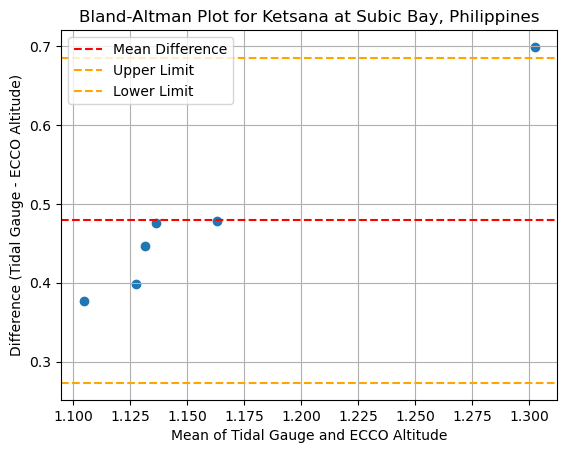

In [44]:
# look into 1 plot
event = "Ketsana"
locat = "Subic Bay, Philippines"
plot_bland_altman(event, locat, ar_allLoc_allEvent_tg, ar_allLoc_allEvent_sat, save_fig=True, plot_fig=True)

## Separated sources

### Just the tidal gauge

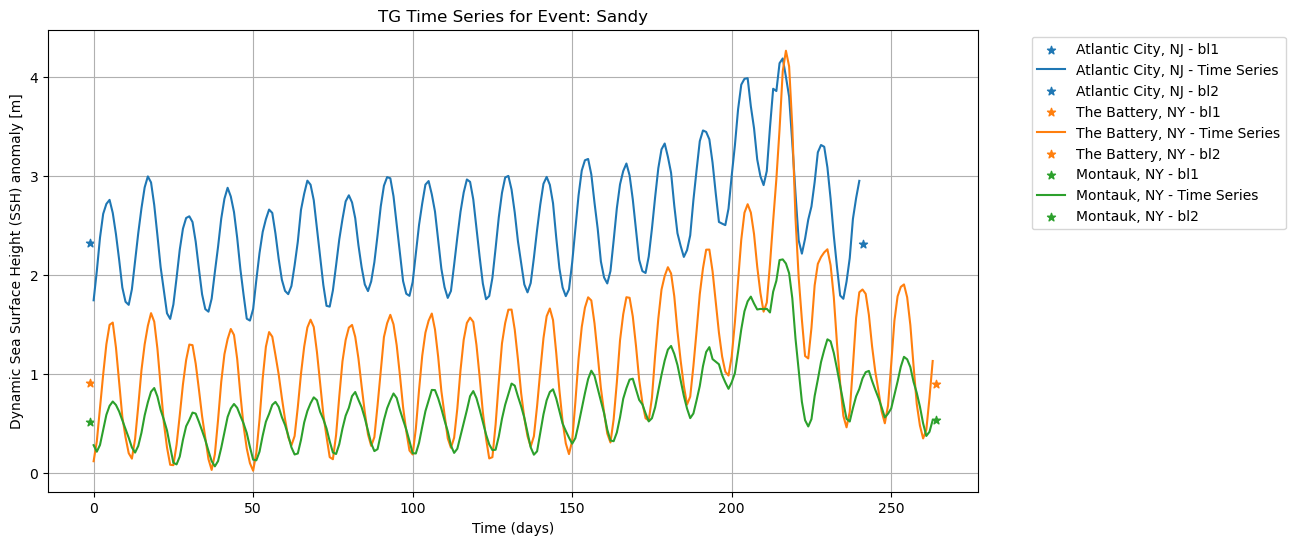

In [173]:
plot_time_series(
    
    ar_allLoc_allEvent_tg, 
    baseline_dict = bl_allLoc_allEvent_tg,

    event = "Sandy",
    
    type = "TG",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

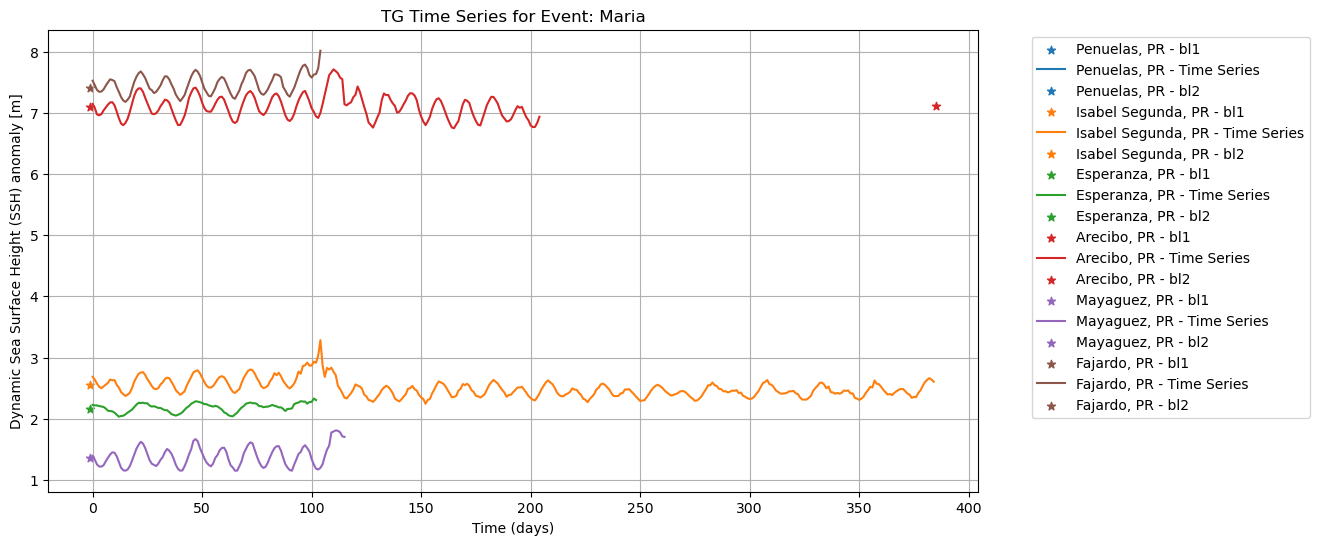

In [174]:
plot_time_series(
    
    ar_allLoc_allEvent_tg, 
    baseline_dict = bl_allLoc_allEvent_tg,

    event = "Maria",
    
    type = "TG",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

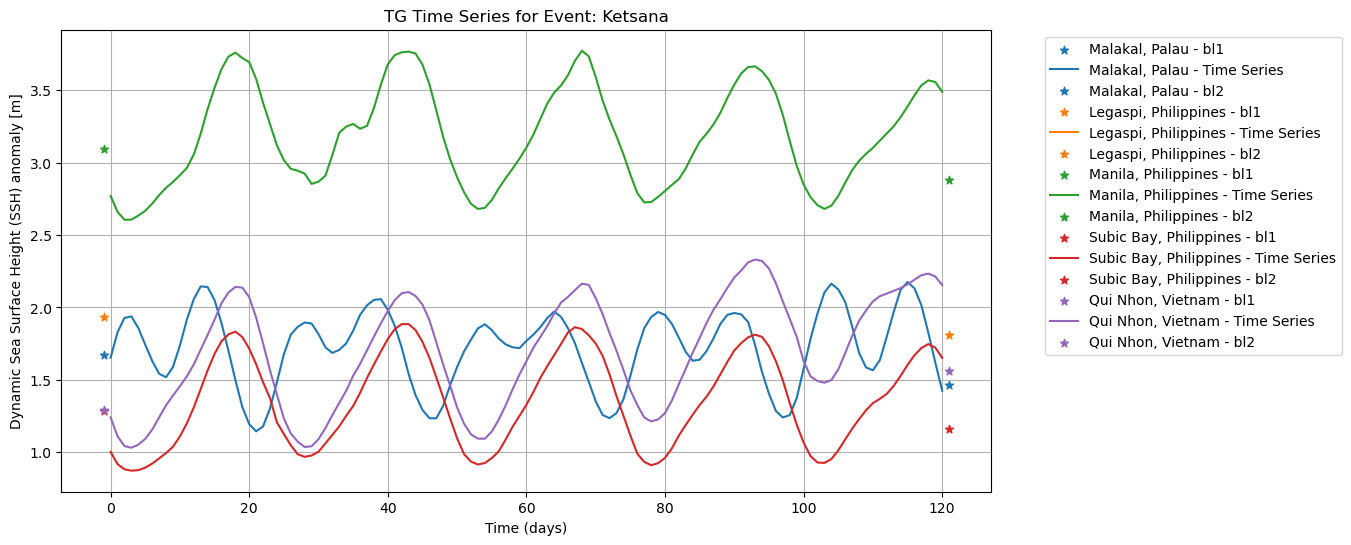

In [175]:
plot_time_series(
    
    ar_allLoc_allEvent_tg, 
    baseline_dict = bl_allLoc_allEvent_tg,

    event = "Ketsana",
    
    type = "TG",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

### Just the satelite

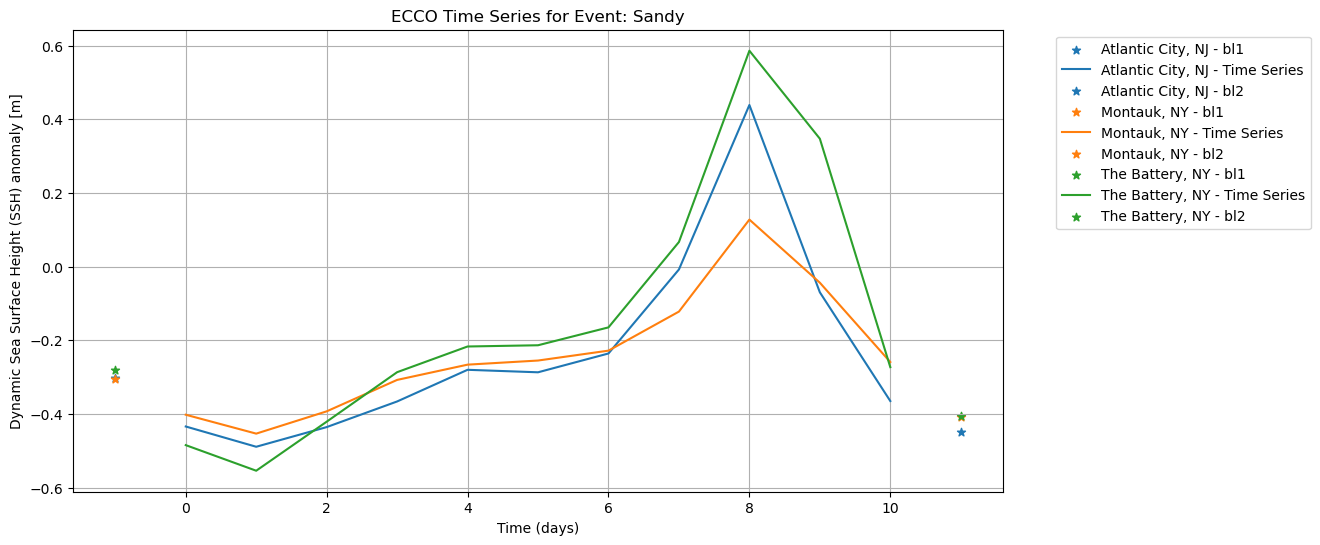

In [176]:
plot_time_series(
    
    ar_allLoc_allEvent_sat, 
    baseline_dict = bl_allLoc_allEvent_sat,

    event = "Sandy",
    
    type = "ECCO",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

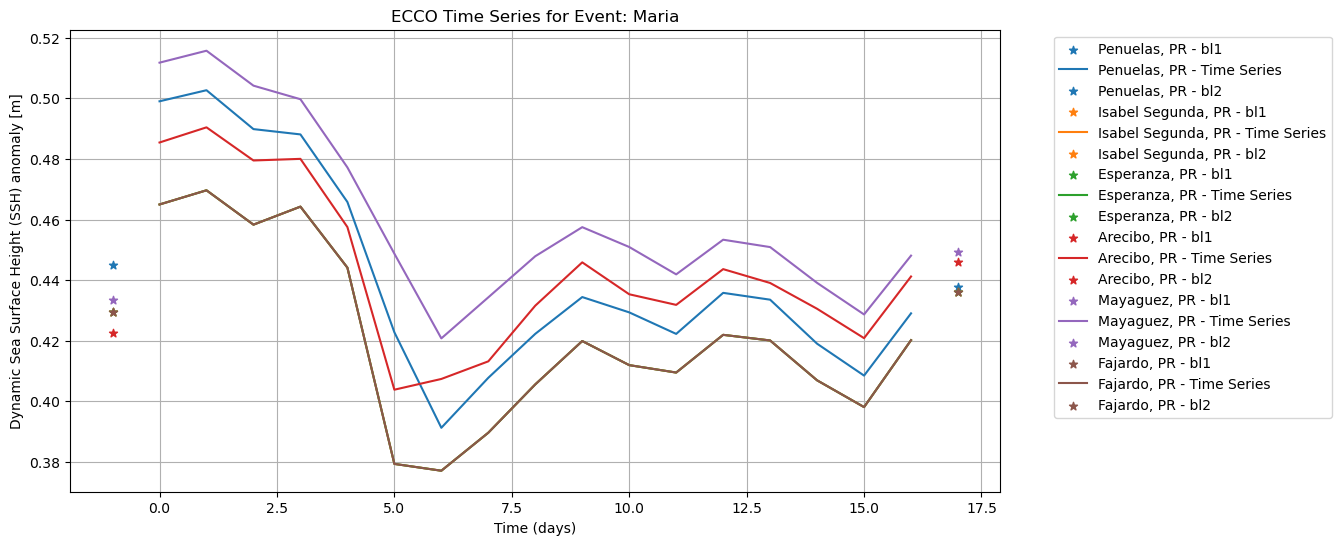

In [177]:
plot_time_series(
    
    ar_allLoc_allEvent_sat, 
    baseline_dict = bl_allLoc_allEvent_sat,

    event = "Maria",
    
    type = "ECCO",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

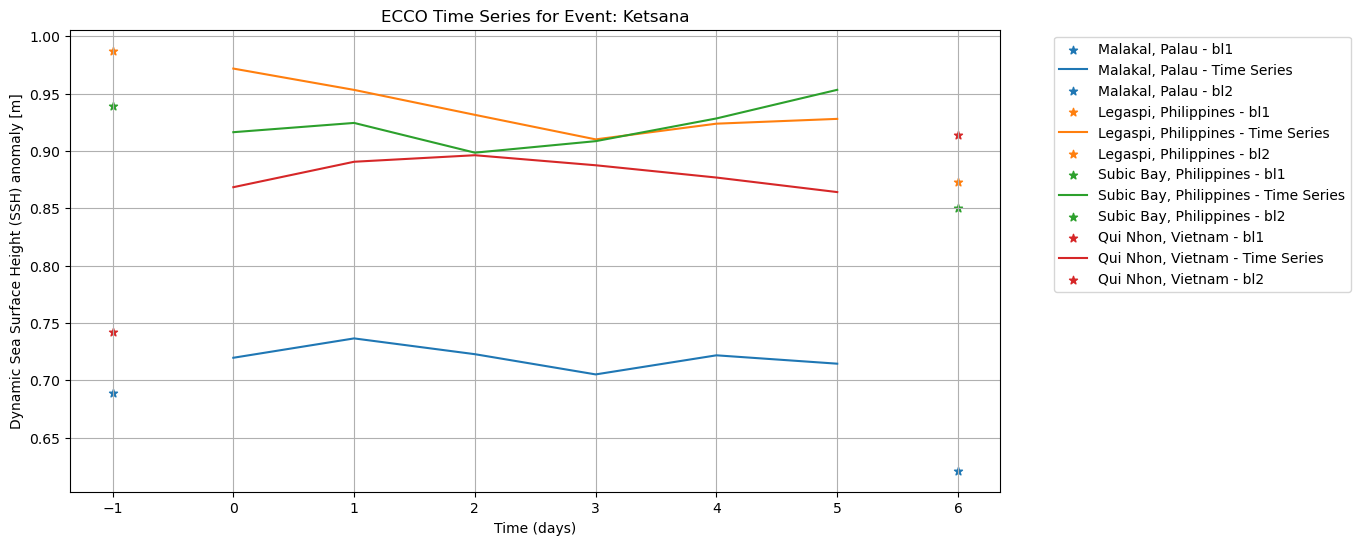

In [178]:
plot_time_series(
    
    ar_allLoc_allEvent_sat, 
    baseline_dict = bl_allLoc_allEvent_sat,

    event = "Ketsana",
    
    type = "ECCO",
    xlabel = "Time (days)",
    ylabel = "Dynamic Sea Surface Height (SSH) anomaly [m]",
    
    save_fig=True, 
    plot_fig=True
    
    )

# event = "Sandy"
# plot_time_series(ar_allLoc_allEvent_tg, event, baseline_dict = bl_allLoc_allEvent_tg,
#                 xlab="Time [hours]", ylab="Sea Surface Height (SSH) [m]", type_sensor="Tidal-Gauge")

## Combined sources

### Normalized plot of **both** satellite and TG (TG are resampled to daily)

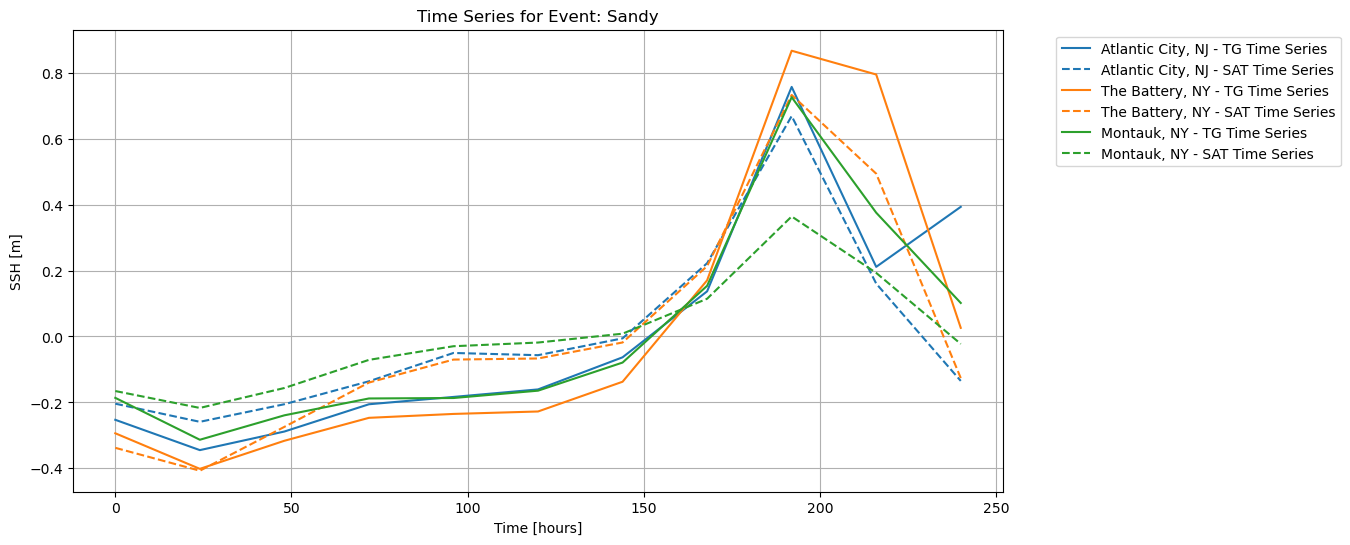

In [159]:
event = "Sandy"
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event, 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=True,
    save_fig=True, plot_fig=True)

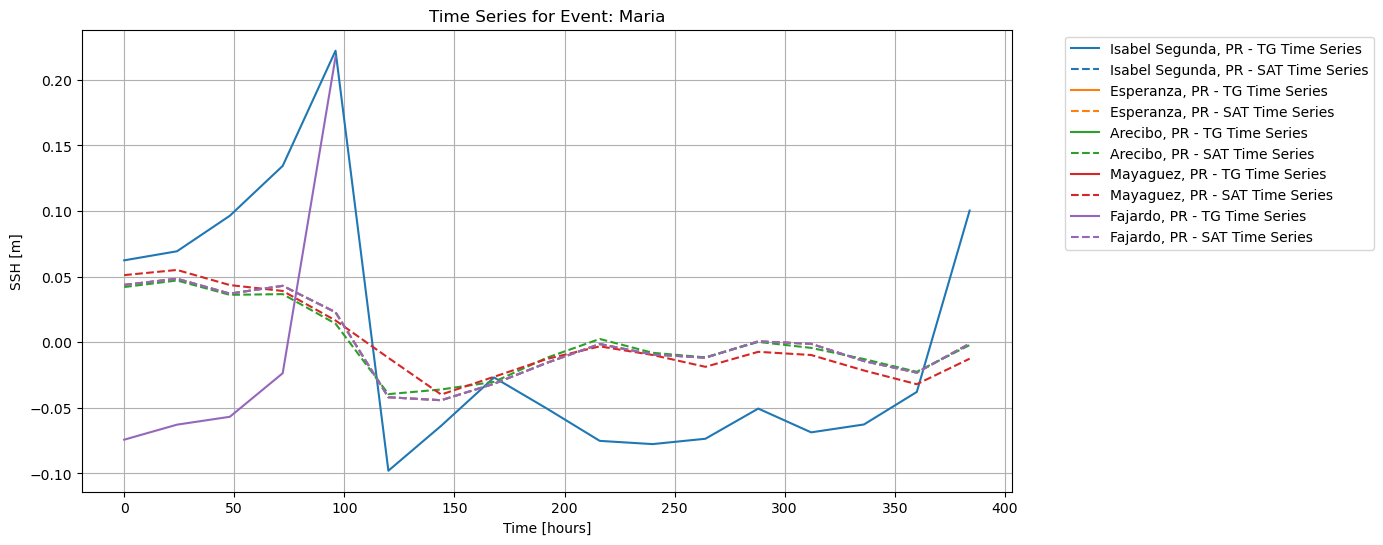

In [160]:
event = "Maria"
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event, 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=True,
    save_fig=True, plot_fig=True)

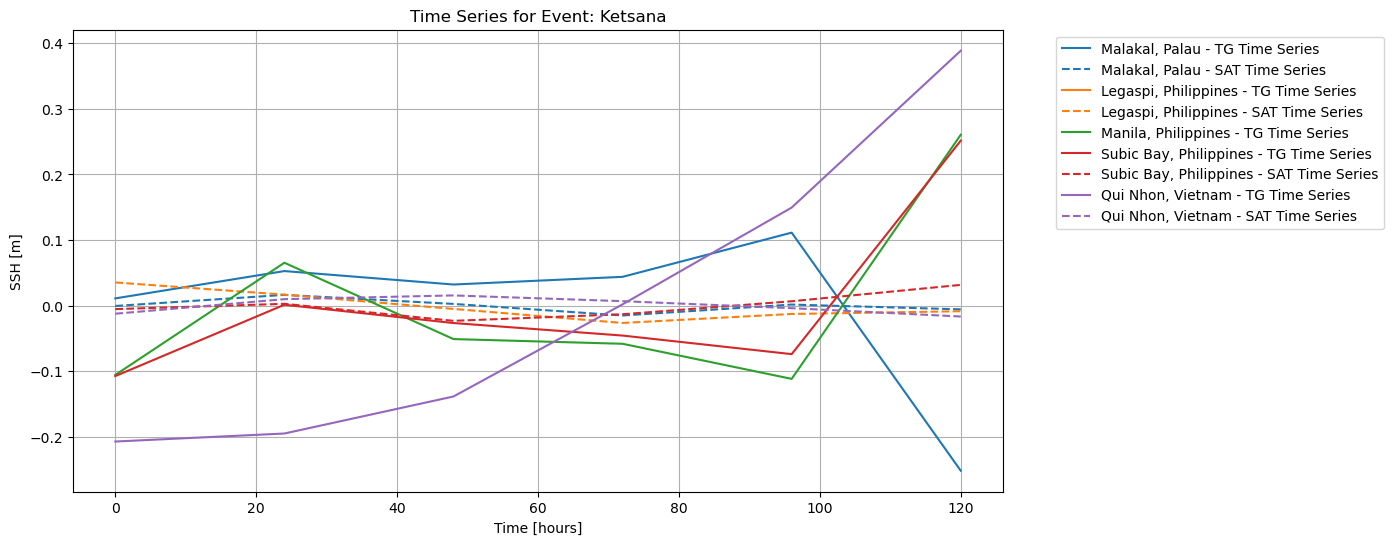

In [161]:
event = "Ketsana"
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event, 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=True,
    save_fig=True, plot_fig=True)

### Normalized plot of **both** satellite and TG (not resampled)

> CAUTION: FOR THE FOLLOWING PLOT TO WORK, BE SURE THAT THE TG DATA HAS NOT BEEN RESAMPLED INSIDE THE `ar_allLoc_allEvent_tg` DICTIONNARY.
> If it did, then go back to the `Second, getting the TG data` to set the `resample_tg` variable to `False``

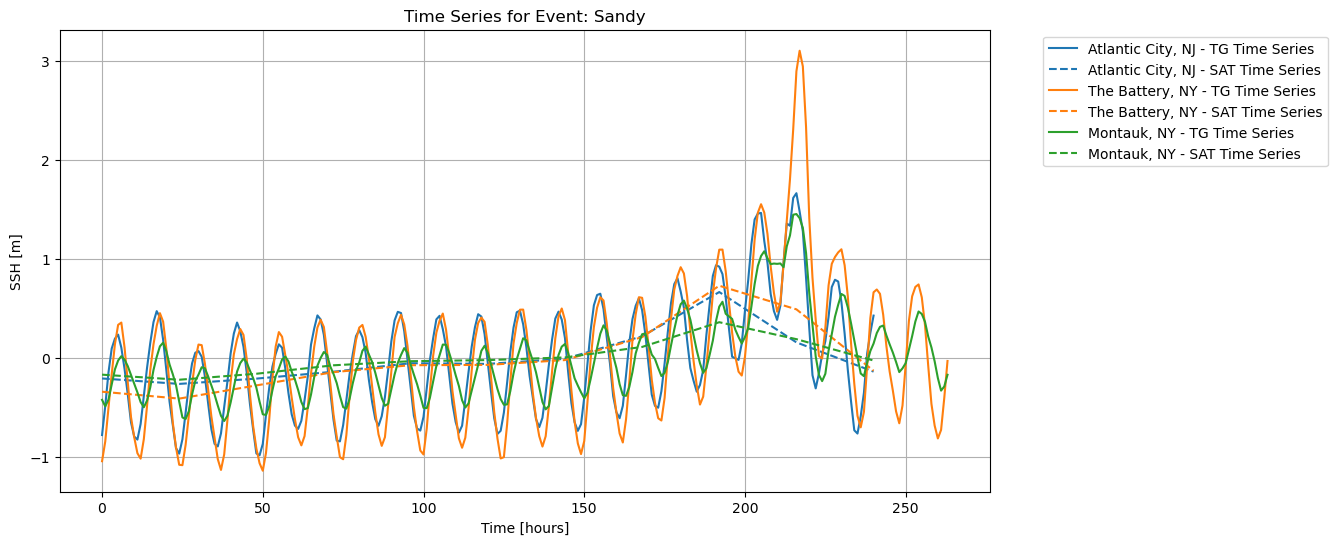

In [167]:
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event = "Sandy", 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=False,
    save_fig=True, plot_fig=True)

/var/folders/vv/stc9rswn5c95vxdzpx7z6qqr0000gn/T/ipykernel_36300/299498353.py:32: RuntimeWarning: Mean of empty slice.
  tg_values = tg_values - tg_values.mean()
/Users/zoubou/opt/anaconda3/envs/CMA_2023/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


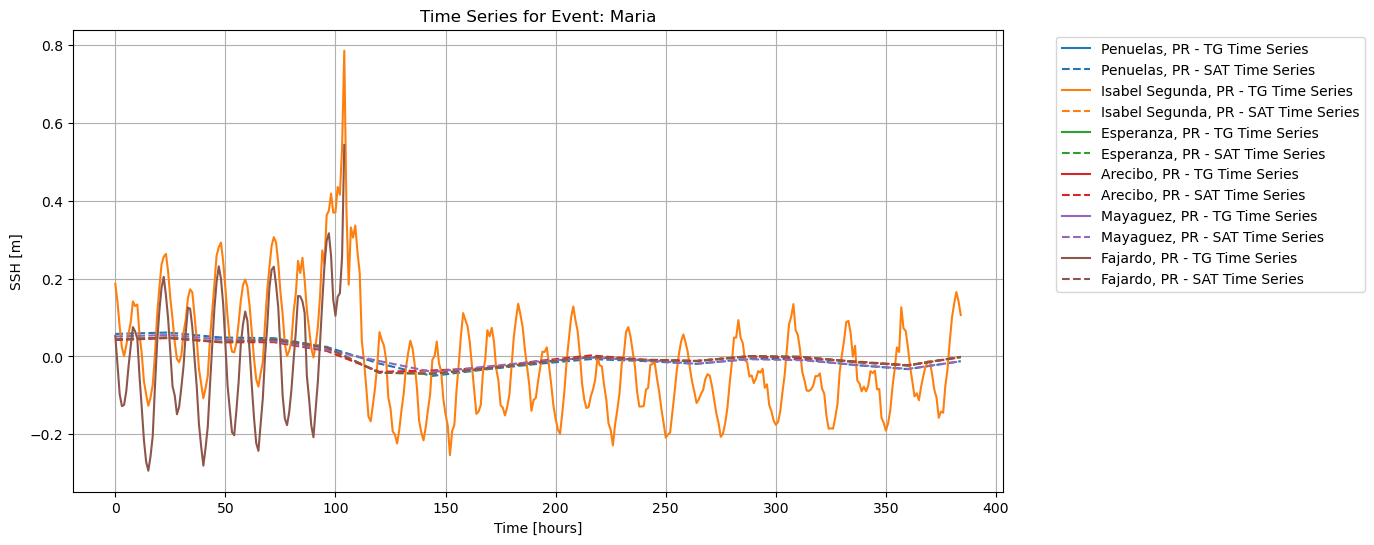

In [169]:
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event = "Maria", 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=False,
    save_fig=True, plot_fig=True)

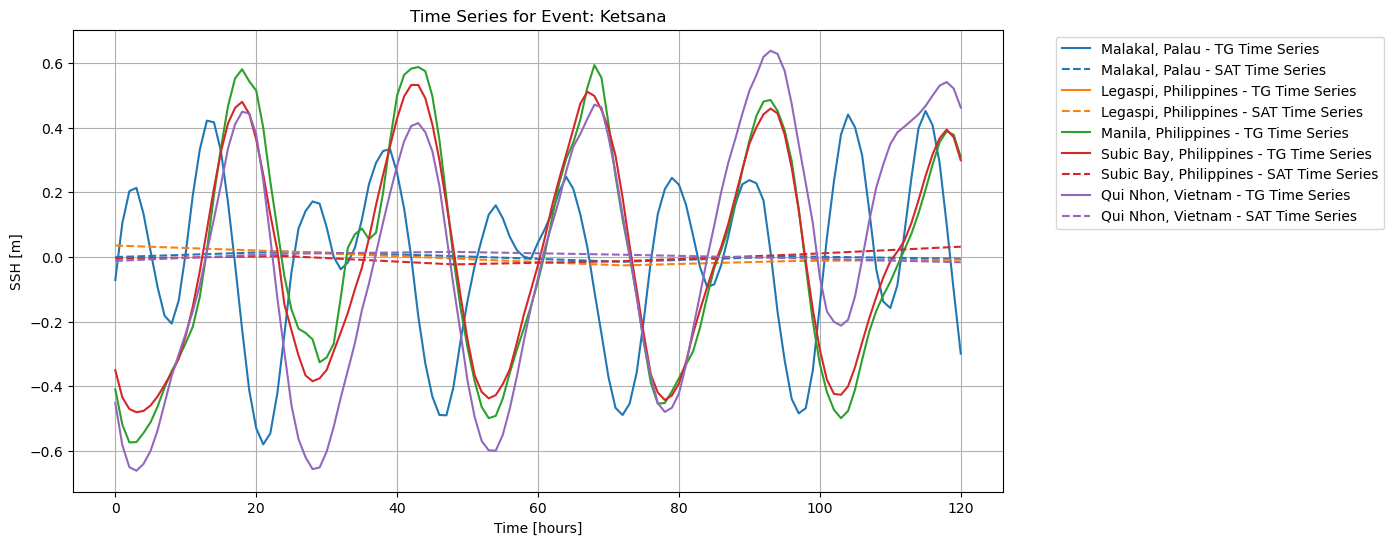

In [170]:
plot_time_series_combined(
    ar_allLoc_allEvent_tg, 
    ar_allLoc_allEvent_sat, 
    event = "Ketsana", 
    xlab="Time [hours]", ylab="SSH [m]",
    baseline_dict=True, 
    normalize_zero=True,
    resample_tg=False,
    save_fig=True, plot_fig=True)